# ✨ **Medical Data Science Tutorial**

## 📁 Download Data and Package (clone the repo if using colab)

---



In [ ]:
# Download Data
! rm -r Medical_Data_Science_Tutorial
! git clone https://github.com/hardness1020/Medical_Data_Science_Tutorial.git

rm: cannot remove 'Medical_Data_Science_Tutorial': No such file or directory
Cloning into 'Medical_Data_Science_Tutorial'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 21 (delta 3), pack-reused 0
Receiving objects: 100% (21/21), 142.25 KiB | 2.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
! pip3 install --quiet -r Medical_Data_Science_Tutorial/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss

# Model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Cindex
from lifelines.utils import concordance_index

# evaluation
from sklearn.metrics import accuracy_score, f1_score

# Self File (using colab)
from Medical_Data_Science_Tutorial.utils.selected_features import Features
from Medical_Data_Science_Tutorial.utils.KM_survival_analysis import KMSurvivalCurve
from Medical_Data_Science_Tutorial.utils.get_image_bytes import get_confusion_matrix_bytes
from Medical_Data_Science_Tutorial.utils.aml_spliter import AMLSpliter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🔧 Method

---



### 1. Data Preprocessing

In [ ]:
BASE_PATH = './Medical_Data_Science_Tutorial'
CUTOFF = 2  # Month

_ncri_df = pd.read_csv(f'{BASE_PATH}/dataset/NCRI.tsv', sep=' ')
_sg_df = pd.read_csv(f'{BASE_PATH}/dataset/SG.tsv', sep=' ')
features = Features()

#### 1.1 Prepare Cohort for Training and Validation (NCRI)

In [ ]:
# Preprocessing NCRI cohort

ncri_df = _ncri_df.copy().reset_index()
ncri_df = ncri_df.rename(columns={
            'index'     : '病歷號',

            'gender'    : 'Gender',
            'age'       : 'Age',

            'wbc'       : 'WBC',
            'hb'        : 'Hb',
            'plt'       : 'Plt',
            'bm_blasts' : 'PB_Blast',

            # mutations
            'FLT3_TKD'  : 'FLT_TKD',

            'os'        : 'OSD_no_censor_2021',
            'os_status' : 'OS_coding_no_censor_2021',
            'eln_2017'  : 'ELN_2017',
            })

# Lack of mutations : Rad21, STAG1, c-CBL, CBL-b
# Lack of karyotypes: del(5q), t(16;16), t(3;3)
ncri_df['Rad21'] = 0
ncri_df['STAG1'] = 0
ncri_df['c-CBL'] = 0
ncri_df['CBL-b'] = 0
ncri_df['del(5q)'] = 0
ncri_df['t(16;16)'] = 0
ncri_df['t(3;3)'] = 0

# NRAS : "NRAS_other" "NRAS_p.G12_13" "NRAS_p.Q61_62"
# IDH2 : "IDH2_p.R140" "IDH2_p.R172"
# U2AF1: "U2AF1_p.S34" "U2AF1_p.Q157"
ncri_df['NRAS'] = ncri_df[['NRAS_other', 'NRAS_p.G12_13', 'NRAS_p.Q61_62']].any(axis=1).map({True: 1, False: 0})
ncri_df['IDH2'] = ncri_df[['IDH2_p.R140', 'IDH2_p.R172']].any(axis=1).map({True: 1, False: 0})
ncri_df['U2AF1'] = ncri_df[['U2AF1_p.S34', 'U2AF1_p.Q157']].any(axis=1).map({True: 1, False: 0})
ncri_df['ELN_2017'] = ncri_df['ELN_2017'].map({3: 2, 2: 1, 1: 0})

# Select Features
ncri_df = ncri_df[features.reference + features.gender_data + features.age_data + features.blood_data + \
                  features.karyotype_data + features.mutation_data + \
                  ['ELN_2017', 'OSD_no_censor_2021', 'OS_coding_no_censor_2021']]
ncri_df['cohort'] = 'NCRI'

print('Number of samples: ', ncri_df.shape[0])

Number of samples:  2113


In [ ]:
# Filter the data

# Remove the Survival Sample with Observation Period < 2 Month
"""
OS_coding_no_censor_2021: 0 (not dead) / 1 (dead)
OSD_no_censor_2021: months of observation period
"""
ncri_df = ncri_df.loc[~((ncri_df['OS_coding_no_censor_2021']==0) & (ncri_df['OSD_no_censor_2021']<CUTOFF)), :].copy()
print('Number of sample after remove the survival sample with observation period < 2 month: ', ncri_df.shape[0])
print()

# Label the Data
OS_adverse_group_threshold = 0.8  # Month
OS_intermediate_group_threshold = 4
ncri_df.loc[:, 'OS_label'] =     \
    ncri_df['OSD_no_censor_2021'].map(lambda x: 0 if x < OS_adverse_group_threshold
                                                      else (1 if x < OS_intermediate_group_threshold else 2))
print('Number of adverse     : ', ncri_df[ncri_df['OS_label']==0].shape[0])
print('Number of intermediate: ', ncri_df[ncri_df['OS_label']==1].shape[0])
print('Number of favorable   : ', ncri_df[ncri_df['OS_label']==2].shape[0])

if not os.path.exists('./data_preprocessed'):
    os.makedirs(f'./data_preprocessed')
ncri_df.to_csv(f'./data_preprocessed/NCRI.csv', sep=',', index=False)

Number of sample after remove the survival sample with observation period < 2 month:  2082

Number of adverse     :  710
Number of intermediate:  712
Number of favorable   :  660


#### 1.2 Prepare Cohort for Training and Validation (SG)

In [ ]:
# Preprocessing SG chort

sg_df = _sg_df.copy().reset_index()
sg_df = sg_df.rename(columns={
            'index'     : '病歷號',

            'HB'        : 'Hb',
            'PLT'       : 'Plt',
            'BM_Blasts' : 'PB_Blast',

            # mutations
            'FLT3_TKD'  : 'FLT_TKD',
            'RAD21'     : 'Rad21',

            'OS'        : 'OSD_no_censor_2021',
            'OS_Status' : 'OS_coding_no_censor_2021',
            'eln_2017'  : 'ELN_2017',
            })

# Lack of karyotypes: del(5q), t(16;16), t(3;3), t(8;16)
# Lack of mutations: SMC1A, SMC3, STAG1, c-CBL, CBL-b
sg_df['del(5q)'] = 0
sg_df['t(16;16)'] = 0
sg_df['t(3;3)'] = 0
sg_df['t(8;16)'] = 0
sg_df['SMC1A'] = 0
sg_df['SMC3'] = 0
sg_df['STAG1'] = 0
sg_df['c-CBL'] = 0
sg_df['CBL-b'] = 0

sg_df['ELN_2017'] = sg_df['ELN_2017'].map({'favorable': 2, 'intermediate': 1, 'adverse': 0})

# Select Features
sg_df = sg_df[features.reference + features.gender_data + features.age_data + features.blood_data + \
              features.karyotype_data + features.mutation_data + \
              ['ELN_2017', 'OSD_no_censor_2021', 'OS_coding_no_censor_2021']]
sg_df['cohort'] = 'SG'

print('Number of sample: ', sg_df.shape[0])

Number of sample:  1540


In [10]:
##### TODO ####
# Try to do the same thing with `sg_df`, and save the file as `./data_preprocessed/SG.csv`

# Filter the data
# Remove the Survival Sample with Observation Period < 2 Month
sg_df = sg_df.loc[~((sg_df['OS_coding_no_censor_2021']==0) & (sg_df['OSD_no_censor_2021']<CUTOFF)), :].copy()
print('Number of sample after remove the survival sample with observation period < 2 month: ', sg_df.shape[0])
print()

# Label the Data
OS_adverse_group_threshold = 0.8  # Month
OS_intermediate_group_threshold = 4
sg_df.loc[:, 'OS_label'] =     \
    sg_df['OSD_no_censor_2021'].map(lambda x: 0 if x < OS_adverse_group_threshold
                                                      else (1 if x < OS_intermediate_group_threshold else 2))
print('Number of adverse     : ', sg_df[sg_df['OS_label']==0].shape[0])
print('Number of intermediate: ', sg_df[sg_df['OS_label']==1].shape[0])
print('Number of favorable   : ', sg_df[sg_df['OS_label']==2].shape[0])

if not os.path.exists('./data_preprocessed'):
    os.makedirs(f'./data_preprocessed')
sg_df.to_csv(f'./data_preprocessed/SG.csv', sep=',', index=False)


Number of sample after remove the survival sample with observation period < 2 month:  1508

Number of adverse     :  391
Number of intermediate:  558
Number of favorable   :  559


### 2. Training and Prediction

#### 2.1. Config

In [11]:
# Training and validation Set
preprocessing_df = pd.read_csv(f'./data_preprocessed/NCRI.csv')

# Feature used, you may extend it yourself for the bonus question
feature_types = {
    'gender_age_blood_karyotype_mutation':
          features.gender_data +\
          features.age_data +\
          features.blood_data +\
          features.karyotype_data +\
          features.mutation_data
}

# Label
label_column = [features.label_data[1]]        # OS_label
time_column  = [features.label_time_data[1]]   # OS_time
event_column = features.label_coding_data[2]   # OS_event

# Set the number of experiments
RANDOM_STATE = 2023  # Assign random state to 2023

# cohort
cohort = 'NCRI'

#### 2.2 Hyperparameters Optimization
> Train the best combination of hyperparameters

#### 2.3 Training and Prediction
> Use the trained hyperparameters

In [14]:
# Define the Classifier Model

class Classfier(object):
    def __init__(self, X_train, X_validation, y_train, y_validation):
        self.X_train = X_train
        self.X_validation = X_validation
        self.y_train = y_train
        self.y_validation = y_validation

    def process(self, model, **config):
        return getattr(self, model)(**config)

    def rf(self):
        print('Random Forest model')
        model = RandomForestClassifier(random_state = RANDOM_STATE, n_estimators = 100)
        model.fit(self.X_train, self.y_train)
        self.rf_y_train_pred = model.predict(self.X_train)
        self.rf_y_train_pred_proba = model.predict_proba(self.X_train)
        self.rf_y_validation_pred = model.predict(self.X_validation)
        self.rf_y_validation_pred_proba = model.predict_proba(self.X_validation)
        return model, self.rf_y_train_pred, self.rf_y_train_pred_proba, self.rf_y_validation_pred, self.rf_y_validation_pred_proba

    def xgb(self):
        print('XGBoost model')
        ##### TODO #####
        # You can use above code as example, but make sure to meet the output(return)
        model = XGBClassifier(random_state = RANDOM_STATE, n_estimators = 100)
        model.fit(self.X_train, self.y_train)
        self.xgb_y_train_pred = model.predict(self.X_train)
        self.xgb_y_train_pred_proba = model.predict_proba(self.X_train)
        self.xgb_y_validation_pred = model.predict(self.X_validation)
        self.xgb_y_validation_pred_proba = model.predict_proba(self.X_validation)
        return model, self.xgb_y_train_pred, self.xgb_y_train_pred_proba, self.xgb_y_validation_pred, self.xgb_y_validation_pred_proba

    def loss_function_based_ensemble(self, used_models):
        print('Loss function based ensemble model')
        print('Models: ', used_models)

        train_pred_probas = []
        validation_pred_probas = []
        model_weights = []

        if 'rf' in used_models:
            rf_loss = log_loss(self.y_train, self.rf_y_train_pred_proba)
            train_pred_probas.append(self.rf_y_train_pred_proba)
            validation_pred_probas.append(self.rf_y_validation_pred_proba)
            model_weights.append(np.exp(-rf_loss))
        if 'xgb' in used_models:
            xgb_loss = log_loss(self.y_train, self.xgb_y_train_pred_proba)
            train_pred_probas.append(self.xgb_y_train_pred_proba)
            validation_pred_probas.append(self.xgb_y_validation_pred_proba)
            model_weights.append(np.exp(-xgb_loss))

        # calculate weights of each model
        model_weights = np.array(model_weights)
        model_weights /= np.sum(model_weights)

        y_train_pred_proba = np.zeros_like(train_pred_probas[0])
        for i, pred in enumerate(train_pred_probas):
            y_train_pred_proba += model_weights[i] * pred

        y_validation_pred_proba = np.zeros_like(validation_pred_probas[0])
        for i, pred in enumerate(validation_pred_probas):
            y_validation_pred_proba += model_weights[i] * pred

        y_train_pred = np.argmax(y_train_pred_proba, axis=1)
        y_validation_pred = np.argmax(y_validation_pred_proba, axis=1)
        return model_weights, y_train_pred, y_train_pred_proba, y_validation_pred, y_validation_pred_proba

In [16]:
# If 0.2 then test:val = 8:2
TEST_SIZE = 0.2

# Decide which models you want to use
used_models = ['rf', 'xgb']

for feature_name, feature_type in feature_types.items():
    print(f'Feature: {feature_name}')

    # Get best trial with specific random state
    # and then convert hyperopt best params dict from {'': ['']} to {'': ''}
    # and then get the real parameters of best trial

    # Split the data into train and test set by cohort
    aml_data = AMLSpliter(preprocessing_df, features.reference, feature_type, label_column, feature_name)

    """
    def train_test_split_and_normalization_by_cohort(self, cohorts, normalize=True, test_size=0.2, random_state=42):
        '''
        Split the data into train and test set by cohort
        '''

        ...

        if normalize:
            return X_train, X_validation, y_train, y_validation, train_index, test_index, features.preprocessor
        else:
            return X_train, X_validation, y_train, y_validation, train_index, test_index, None

    """
    X_train, X_validation, y_train, y_validation, train_index, validation_index, preprocessor = \
        aml_data.train_test_split_and_normalization_by_cohort(cohorts=[cohort], random_state=RANDOM_STATE, test_size=TEST_SIZE)


    # Classfication
    classfier = Classfier(X_train, X_validation, y_train, y_validation)

    # Calculate each of the models
    for model_name in used_models:
        # Process the model
        model, y_train_pred, y_train_pred_proba, y_validation_pred, y_validation_pred_proba = classfier.process(model_name)

        # Save the Model
        model_file_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{RANDOM_STATE}/{model_name}.{feature_name}.pkl'
        if not os.path.exists(os.path.dirname(model_file_path)):
            os.makedirs(os.path.dirname(model_file_path))
        pickle.dump(model, open(model_file_path, 'wb'))

        # Save the training set prediction result
        prediction_df = pd.DataFrame({
            'sample': preprocessing_df.loc[train_index, features.reference[0]],
            'cohort': preprocessing_df.loc[train_index, 'cohort'],
            'label': y_train,
            'prediction': y_train_pred,
            'prediction_proba_adverse': y_train_pred_proba[:, 0],
            'prediction_proba_intermediate': y_train_pred_proba[:, 1],
            'prediction_proba_favorable': y_train_pred_proba[:, 2],
            'ELN_2017': preprocessing_df.loc[train_index, 'ELN_2017'],
        })
        prediction_file_path = f'./ESB_results/prediction/train/{cohort}/{CUTOFF}/{RANDOM_STATE}/{model_name}.{feature_name}.csv'
        if not os.path.exists(os.path.dirname(prediction_file_path)):
            os.makedirs(os.path.dirname(prediction_file_path))
        prediction_df.to_csv(prediction_file_path, index=False)

        # Save the validation set prediction result
        prediction_df = pd.DataFrame({
            'sample': preprocessing_df.loc[validation_index, features.reference[0]],
            'cohort': preprocessing_df.loc[validation_index, 'cohort'],
            'label': y_validation,
            'prediction': y_validation_pred,
            'prediction_proba_adverse': y_validation_pred_proba[:, 0],
            'prediction_proba_intermediate': y_validation_pred_proba[:, 1],
            'prediction_proba_favorable': y_validation_pred_proba[:, 2],
            'ELN_2017': preprocessing_df.loc[validation_index, 'ELN_2017'],
        })
        prediction_file_path = f'./ESB_results/prediction/validation/{cohort}/{CUTOFF}/{RANDOM_STATE}/{model_name}.{feature_name}.csv'
        if not os.path.exists(os.path.dirname(prediction_file_path)):
            os.makedirs(os.path.dirname(prediction_file_path))
        prediction_df.to_csv(prediction_file_path, index=False)


    # Ensemble models
    model_weights, y_train_pred, y_train_pred_proba, y_validation_pred, y_validation_pred_proba = \
        classfier.loss_function_based_ensemble(used_models)

    # Save the models' weight
    pickle.dump(model_weights, open(f'./ESB_results/models/{cohort}/{CUTOFF}/{RANDOM_STATE}/weights.{feature_name}.pkl', 'wb'))

    ##### TODO #####
    # Please save the ensemble result, in the path:
    # Train: './ESB_results/prediction/train/{cohort}/{CUTOFF}/{RANDOM_STATE}/ensemble.{feature_name}.csv'
    # Test: './ESB_results/prediction/validation/{cohort}/{CUTOFF}/{RANDOM_STATE}/ensemble.{feature_name}.csv'

    # Save the ensemble training set prediction result
    ensemble_train_prediction_df = pd.DataFrame({
        'sample': preprocessing_df.loc[train_index, features.reference[0]],
        'cohort': preprocessing_df.loc[train_index, 'cohort'],
        'label': y_train,
        'prediction': y_train_pred,
        'prediction_proba_adverse': y_train_pred_proba[:, 0],
        'prediction_proba_intermediate': y_train_pred_proba[:, 1],
        'prediction_proba_favorable': y_train_pred_proba[:, 2],
        'ELN_2017': preprocessing_df.loc[train_index, 'ELN_2017'],
    })
    ensemble_train_file_path = f'./ESB_results/prediction/train/{cohort}/{CUTOFF}/{RANDOM_STATE}/ensemble.{feature_name}.csv'
    if not os.path.exists(os.path.dirname(ensemble_train_file_path)):
        os.makedirs(os.path.dirname(ensemble_train_file_path))

    # Save to CSV
    ensemble_train_prediction_df.to_csv(ensemble_train_file_path, index=False)


    # Save the ensemble validation set prediction result
    ensemble_validation_prediction_df = pd.DataFrame({
        'sample': preprocessing_df.loc[validation_index, features.reference[0]],
        'cohort': preprocessing_df.loc[validation_index, 'cohort'],
        'label': y_validation,
        'prediction': y_validation_pred,
        'prediction_proba_adverse': y_validation_pred_proba[:, 0],
        'prediction_proba_intermediate': y_validation_pred_proba[:, 1],
        'prediction_proba_favorable': y_validation_pred_proba[:, 2],
        'ELN_2017': preprocessing_df.loc[validation_index, 'ELN_2017'],
    })
    ensemble_validation_file_path = f'./ESB_results/prediction/validation/{cohort}/{CUTOFF}/{RANDOM_STATE}/ensemble.{feature_name}.csv'
    if not os.path.exists(os.path.dirname(ensemble_validation_file_path)):
        os.makedirs(os.path.dirname(ensemble_validation_file_path))

    # Save to CSV
    ensemble_validation_prediction_df.to_csv(ensemble_validation_file_path, index=False)



Feature: gender_age_blood_karyotype_mutation
Random Forest model
XGBoost model
Loss function based ensemble model
Models:  ['rf', 'xgb']


#### 2.4 Testing: External Cohort

In [17]:
SG_preprocessing_df = pd.read_csv(f'./data_preprocessed/SG.csv')

cohort = 'NCRI'
external_cohort = 'SG'
used_models = ['rf', 'xgb']

for feature_name, feature_type in feature_types.items():
    # NTUH data is for get the normalization preprocessor
    aml_data = AMLSpliter(preprocessing_df, features.reference, feature_type, label_column, feature_name)
    _, _, _, _, _, _, preprocessor = \
        aml_data.train_test_split_and_normalization_by_cohort(cohorts=[cohort], random_state=RANDOM_STATE)

    # Get the features and rearrange the columns of the data
    X_external = SG_preprocessing_df[feature_type].copy()

    # Normalize the data
    X_external[features.age_data + features.blood_data] = preprocessor.transform(X_external)

    # Convert the data type to numpy array
    X_external = X_external.values

    # Predict the probability of each model
    y_pred_probas = []
    for model_type in used_models:
        model_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{RANDOM_STATE}/{model_type}.{feature_name}.pkl'
        model = pickle.load(open(model_path, 'rb'))
        y_pred_probas.append(model.predict_proba(X_external))

    # Load the weights of each model
    weights_path = f'./ESB_results/models/{cohort}/{CUTOFF}/{RANDOM_STATE}/weights.{feature_name}.pkl'
    weights = pickle.load(open(weights_path, 'rb'))
    weights = np.array(weights)

    # Ensemble the probability of each model
    y_pred_proba = np.zeros_like(y_pred_probas[0])
    for i, pred in enumerate(y_pred_probas):
        y_pred_proba += weights[i] * pred
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Save the prediction result
    df = SG_preprocessing_df[['病歷號', 'cohort', 'ELN_2017', 'OS_label']]
    df['prediction'] = y_pred
    df = df.rename(columns={'病歷號': 'sample', 'OS_label': 'label'})

    path = f'./ESB_results/prediction/external/{external_cohort}/{CUTOFF}/{RANDOM_STATE}/ensemble.{feature_name}.csv'
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    df.to_csv(path, sep=',', index=False)

## 📊 Analysis for Ensemble Model

---



### 1. Config and Read Data



In [18]:
# Config

filename = 'ensemble.gender_age_blood_karyotype_mutation.csv'
reference = 'ELN_2017'

# The features used in the model
numerical_columns   = ['Age', 'WBC', 'Hb', 'Plt', 'PB_Blast']
categorical_columns = ['Gender', 'PTPN11', 'NRAS', 'KRAS', 'NPM1', 'FLT_TKD', 'MLL', 'KIT', 'RUNX1',
                       'WT1', 'ASXL1', 'IDH1', 'IDH2', 'TET2', 'DNMT3A', 'TP53', 'SF3B1', 'U2AF1',
                       'SRSF2', 'ZRSR2', 'GATA2', 'STAG2', 'PHF6', 'ETV6', 'EZH2', 'BCOR',
                       'Rad21', 'STAG1', 'c-CBL', 'CBL-b', 'SMC1A', 'SMC3',
                       't(8;21)', 'inv(16)', 't(16;16)', 't(9;11)', 't(6;9)', 't(9;22)', 't(8;16)',
                       'inv(3)', 't(3;3)', '-5', 'del(5q)', '-7', '-17']

time_columns = ['OSD_no_censor_2021']
event_columns = ['OS_coding_no_censor_2021']

In [19]:
# Read the preprocessed data

_NCRI_df = pd.read_csv(f'./data_preprocessed/NCRI.csv')
NCRI_df = _NCRI_df[['病歷號']+numerical_columns+categorical_columns+time_columns+event_columns].copy()
NCRI_df = NCRI_df.rename(columns={'病歷號': 'sample'})

_SG_df = pd.read_csv(f'./data_preprocessed/SG.csv')
SG_df = _SG_df[['病歷號']+numerical_columns+categorical_columns+time_columns+event_columns].copy()
SG_df = SG_df.rename(columns={'病歷號': 'sample'})

In [28]:
# Read the prediction data

df_training = pd.read_csv(f'./ESB_results/prediction/train/NCRI/{CUTOFF}/{RANDOM_STATE}/{filename}', sep=',')
df_validation = pd.read_csv(f'./ESB_results/prediction/validation/NCRI/{CUTOFF}/{RANDOM_STATE}/{filename}', sep=',')
df_external = pd.read_csv(f'./ESB_results/prediction/external/SG/{CUTOFF}/{RANDOM_STATE}/{filename}', sep=',')

df_training['sample'] = df_training['sample'].astype(str)
df_validation['sample'] = df_validation['sample'].astype(str)
df_external['sample'] = df_external['sample'].astype(str)


# Merge the features
##### TODO #####
# Merge the dataframes (df_training, df_validation, df_external) with NCRI_df, SG_df accordingly, on `sample`

# Merging the training dataframe with NCRI_df
df_training = df_training.merge(NCRI_df, on='sample', how='inner')

# Merging the validation dataframe with NCRI_df
df_validation = df_validation.merge(NCRI_df, on='sample', how='inner')

# Merging the external dataframe with SG_df
df_external = df_external.merge(SG_df, on='sample', how='inner')

print(df_training.head(3))
print(df_validation.head(3))
print(df_external.head(3))
################

     sample cohort  label  prediction  prediction_proba_adverse  \
0  PD25611a   NCRI      1           1                  0.131331   
1  PD15418a   NCRI      0           0                  0.837566   
2  PD25276a   NCRI      2           2                  0.062905   

   prediction_proba_intermediate  prediction_proba_favorable  ELN_2017  \
0                       0.861328                    0.007341         0   
1                       0.120134                    0.042301         2   
2                       0.085803                    0.851292         2   

         Age   WBC  ...  t(9;22)  t(8;16)  inv(3)  t(3;3)  -5  del(5q)  -7  \
0  85.371663  15.6  ...        0        0       0       0   0        0   1   
1  71.422313  24.5  ...        0        0       0       0   0        0   0   
2  60.188912  15.4  ...        0        0       0       0   0        0   0   

   -17  OSD_no_censor_2021  OS_coding_no_censor_2021  
0    0            0.818617                         1  
1    0     

### 2. Performance

In [29]:
def performance(df):
    # Accuracy
    acc_ELN2017 = accuracy_score(df['label'], df['ELN_2017'])
    acc_ESB = accuracy_score(df['label'], df['prediction'])

    # F1-score
    f1_ELN2017 = f1_score(df['label'], df['ELN_2017'], average='weighted')
    f1_ESB = f1_score(df['label'], df['prediction'], average='weighted')

    # C-index
    cindex_ELN2017 = concordance_index(df[time_columns[0]], df['ELN_2017'], df[event_columns[0]])
    cindex_ESB = concordance_index(df[time_columns[0]], df['prediction'], df[event_columns[0]])

    # Plot survival curve
    kmf_ELN2017 = KMSurvivalCurve(df, time_column=time_columns[0], event_column=event_columns[0],
                                         label_column='ELN_2017', title='ELN 2017')
    kmf_ESB = KMSurvivalCurve(df, time_column=time_columns[0], event_column=event_columns[0],
                                            label_column='prediction', title='Ensemble (ML)')
    byte = kmf_ELN2017.return_survival_curve_bytes()
    byte = kmf_ESB.return_survival_curve_bytes()

    df_performance = pd.DataFrame({
        'model'    : ['ELN 2017', 'Ensemble'],
        'Accuracy' : [f'{acc_ELN2017:.2f}', f'{acc_ESB:.2f}'],
        'F1-score' : [f'{f1_ELN2017:.2f}', f'{f1_ESB:.2f}'],
        'C-index' : [f'{cindex_ELN2017:.2f}', f'{cindex_ESB:.2f}'],
        'p-value (adverse vs. intermediate)' : [f'{kmf_ELN2017.get_pvalue_by_label(0, 1):.1E}', \
                                                f'{kmf_ESB.get_pvalue_by_label(0, 1):.1E}'],
        'p-value (intermediate vs. favorable)' : [f'{kmf_ELN2017.get_pvalue_by_label(1, 2):.1E}', \
                                                  f'{kmf_ESB.get_pvalue_by_label(1, 2):.1E}']
    })

    return df_performance

#### 2.1. Performance of the training set

,model,Accuracy,F1-score,C-index,p-value (adverse vs. intermediate),p-value (intermediate vs. favorable)
0,ELN 2017,0.46,0.45,0.61,1.8E-13,6.7E-09
1,Ensemble,1.00,1.00,0.86,7.0E-310,1.6E-213


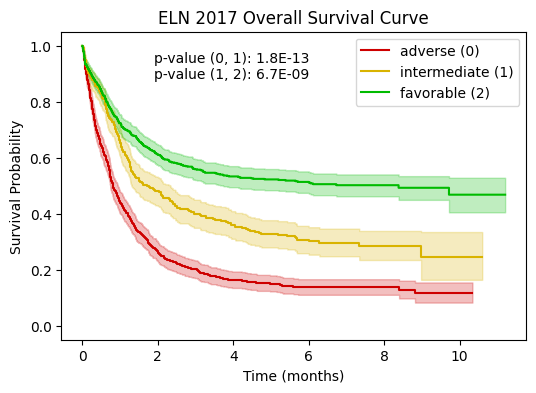

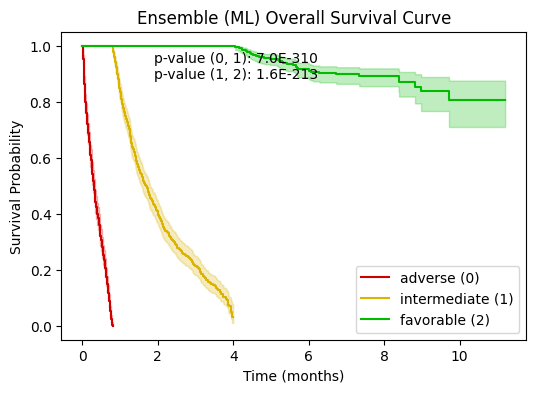

In [30]:
display(performance(df_training))

#### 2.2. Performance of the validation set

,model,Accuracy,F1-score,C-index,p-value (adverse vs. intermediate),p-value (intermediate vs. favorable)
0,ELN 2017,0.47,0.46,0.61,2.8E-04,1.4E-02
1,Ensemble,0.56,0.55,0.66,4.6E-08,1.2E-04


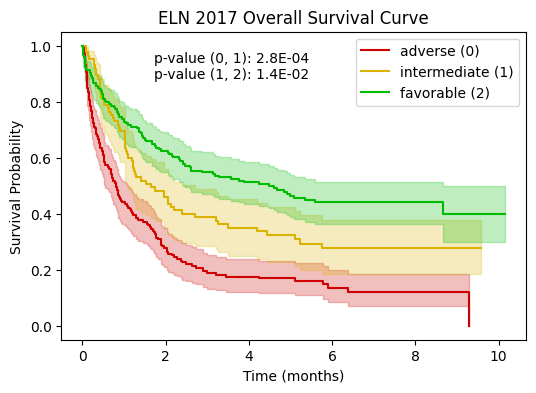

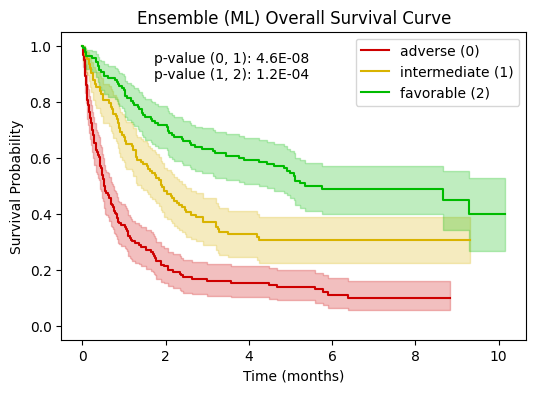

In [31]:
display(performance(df_validation))

#### 2.2. Performance of the external cohort

,model,Accuracy,F1-score,C-index,p-value (adverse vs. intermediate),p-value (intermediate vs. favorable)
0,ELN 2017,0.46,0.45,0.62,7.4E-07,1.1E-14
1,Ensemble,0.46,0.44,0.61,4.5E-14,9.5E-08


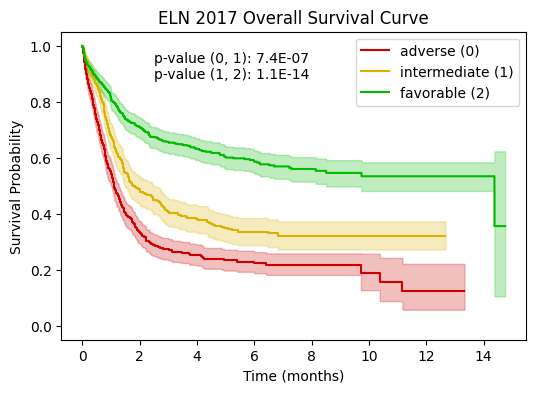

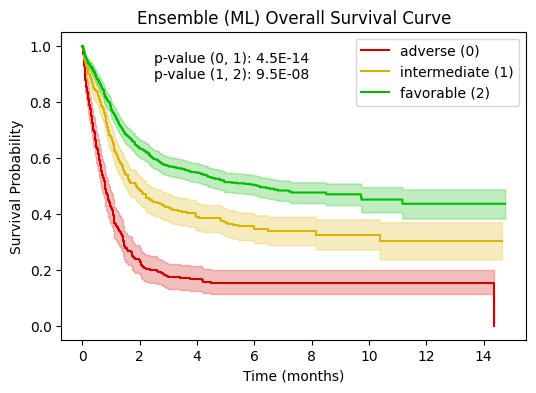

In [32]:
display(performance(df_external))